#Obman_Imgdemo
This is the colab for obman</br>
from: https://github.com/hassony2/obman_train</br>
The algorithm is to predict the hands poses from 2D image and output 2D and 3D information.Also, it will output the coordination for hand joints (total 21),which is benifit to those who need to do hand contact avoidance, hand poses estimation, teleoperation and etc.</br>
Moreover, if you want to run this code, please download the package in https://github.com/richtong888/obman_imgdemo_colab.git and hope you enjoy the code</br>

Modified by RichTong in 20201223


In [ ]:
%git clone https://github.com/richtong888/obman_imgdemo_colab.git

UsageError: Line magic function `%git` not found.


##Mounting packages from your drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sys.path.append('/content/drive/MyDrive/obman-hand-object-interaction/')
%cd /content/drive/MyDrive/obman-hand-object-interaction/
%ls

/content/drive/MyDrive/obman-hand-object-interaction
catkin_make.sh  environment.yml      mano_train/      rviz/
catkin_ws/      examples/            misc/            scripts/
Docker/         handobjectdatasets/  pyproject.toml   setup.py
docker_join.sh  image_demo.py        readme_assets/   test/
docker_run.sh   LICENSE              README.md        traineval.py
environment.sh  manopth/             release_models/  webcam_demo.py


#Import and Install dependancise


In [ ]:
import argparse
from copy import deepcopy
import os
import pickle

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

from matplotlib import pyplot as plt

In [ ]:
import numpy as np
from PIL import Image
!pip install trimesh==2.38.39
!pip install chumpy



     |████████████████████████████████| 337kB 4.1MB/s 
  Created wheel for trimesh: filename=trimesh-2.38.39-cp36-none-any.whl size=377397 sha256=71a4f78335d2375bf278bf6bf9183f6170dd9b024c2d1fbc8aae18040bf59313
  Stored in directory: /root/.cache/pip/wheels/35/3b/6c/84c2975652c99b2ed451af0551a5d7e1c7d437f90185ef2b46
Successfully built trimesh
     |████████████████████████████████| 51kB 3.0MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-cp36-none-any.whl size=58292 sha256=088ae9f0e0a0492562989294bb5174353f46e9b31f42826a230dbeeaaba04ebc
  Stored in directory: /root/.cache/pip/wheels/0a/73/91/b8dbef9746a907c8c008fc194a9691224ca3371b55f16f1dbd
Successfully built chumpy


In [ ]:
from handobjectdatasets.queries import TransQueries, BaseQueries
from handobjectdatasets.viz2d import visualize_joints_2d_cv2

from mano_train.exputils import argutils
from mano_train.netscripts.reload import reload_model
from mano_train.visualize import displaymano
from mano_train.demo.preprocess import prepare_input, preprocess_frame

#Define functions


In [ ]:
def forward_pass_2d(self, input_image, pred_obj=True):

  sample = {}
  sample[TransQueries.images] = input_image
  sample[BaseQueries.sides] = ["left"]
  sample[TransQueries.joints3d] = input_image.new_ones((1, 21, 3)).float()
  sample["root"] = "wrist"
  if pred_obj:
    sample[TransQueries.objpoints3d] = input_image.new_ones((1, 600, 3)).float()
    _, results, _ = model.forward(sample, no_loss=True)

  return results


#Model path

> Indented block




In [ ]:
path_to_checkpoint = "release_models/hands_only/checkpoint.pth.tar"
obman_checkpoint = "release_models/obman/checkpoint.pth.tar"
path_to_image = "readme_assets/images/8.png"
mano_model_name = "misc/mano/MANO_RIGHT.pkl" 
obamn_model_name = "release_models/obman/opt.pkl"
path_to_checkpoint = os.path.dirname("release_models/hands_only/checkpoint.pth.tar")
with open(os.path.join(path_to_checkpoint,"opt.pkl"), "rb") as opt_fh:
  opts_hands = pickle.load(opt_fh)
with open(obman_checkpoint,"rb") as opt_fo:
  opts_obman = pickle.load(opt_fo)  
print(opts_hands)
print(opts_obman)
print(opt_fo)
print(opt_fh)
print(path_to_checkpoint)

{'train_datasets': ['panoptic', 'synthands_30', 'synthands_36', 'synthgrasps_33', 'fhbhands_hand', 'stereohands', 'zimsynth', 'tomasreal'], 'mini_factor': 0.0, 'sides': 'left', 'mode': 'all', 'fhbhands_split_type': 'subjects', 'fhbhands_split_choice': None, 'fhbhands_filter_object': None, 'fhbhands_topology': None, 'synthgrasp_class_ids': None, 'override_scale': False, 'train_splits': ['train', 'train', 'train', 'train', 'train', 'train', 'train', 'train'], 'val_datasets': ['panoptic'], 'val_splits': ['test'], 'controlled_exp': False, 'controlled_size': 60000, 'synthgrasps_segment': False, 'center_idx': 9, 'network': 'manonet', 'right_only': False, 'hidden_neurons': [512, 256], 'ae_bottleneck': 512, 'use_shape': True, 'resnet_version': 18, 'absolute_lambda': 0, 'atlas_residual': False, 'atlas_resume': None, 'atlas_separate_encoder': False, 'atlas_lambda': 0.0, 'atlas_loss': 'chamfer', 'atlas_emd_regul': 0.0, 'atlas_final_lambda': 0.0, 'atlas_mesh': True, 'atlas_mode': 'sphere', 'atlas_

#Initialize network

In [ ]:
model = reload_model("release_models/hands_only/checkpoint.pth.tar", opts_hands,no_beta=False)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/content/drive/My Drive/obman-hand-object-interaction/manopth/manolayer.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


=> loading checkpoint 'release_models/hands_only/checkpoint.pth.tar'


DataParallel(
  (module): HandNet(
    (base_net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [ ]:
with open("misc/mano/MANO_RIGHT.pkl", "rb") as p_f:
  mano_right_data = pickle.load(p_f, encoding="latin1")
  faces = mano_right_data["f"]

#Main Source code


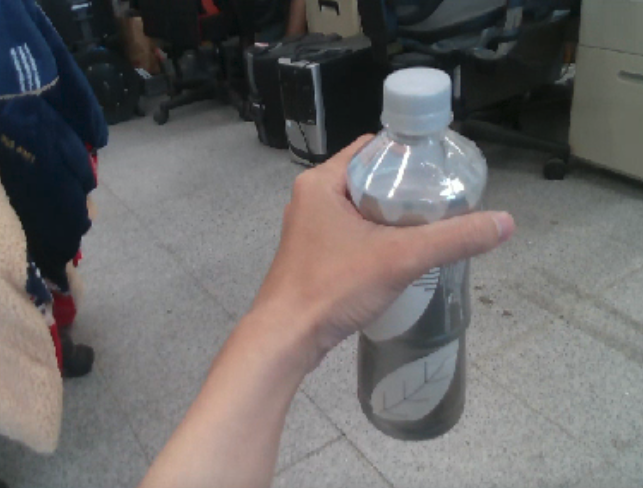

<Figure size 288x288 with 0 Axes>

[[[ 84  48  26]
  [ 77  44  24]
  [ 75  42  23]
  ...
  [115 120 113]
  [115 120 112]
  [115 120 113]]

 [[ 83  47  25]
  [ 75  42  22]
  [ 73  41  21]
  ...
  [112 117 109]
  [112 117 110]
  [113 117 110]]

 [[ 82  46  23]
  [ 73  40  19]
  [ 72  40  19]
  ...
  [106 111 104]
  [108 113 105]
  [108 113 105]]

 ...

 [[ 37  38  32]
  [ 37  38  33]
  [ 37  38  34]
  ...
  [137 138 128]
  [134 135 125]
  [131 132 123]]

 [[ 37  37  31]
  [ 37  37  32]
  [ 37  38  32]
  ...
  [136 138 129]
  [132 135 126]
  [127 130 121]]

 [[ 34  36  30]
  [ 35  36  31]
  [ 36  36  32]
  ...
  [141 142 134]
  [140 141 134]
  [131 133 125]]]


In [ ]:
fig = plt.figure(figsize=(4, 4))
fig.clf()
frame = cv2.imread(path_to_image)
cv2_imshow(frame)
print(frame)

In [ ]:
frame = preprocess_frame(frame)
input_image = prepare_input(frame)
img = Image.fromarray(frame.copy())
hand_crop = cv2.resize(np.array(img), (256, 256))
noflip_hand_image = prepare_input(hand_crop, flip_left_right=False)
# flip_hand_image = prepare_input(hand_crop, flip_left_right=True)
# noflip_output = forward_pass_3d(model_obman, noflip_hand_image)
noflip_output = forward_pass_2d(model, noflip_hand_image)
# flip_output = forward_pass_3d(model_obman, flip_hand_image)
# flip_verts = flip_output["verts"].cpu().detach().numpy()[0]
noflip_verts = noflip_output["verts"].cpu().detach().numpy()[0]
print(noflip_verts)

[[ 16.137362   34.956493  -28.602623 ]
 [ 18.081442   45.701363  -29.414192 ]
 [ 26.288622   41.043613  -33.130497 ]
 ...
 [ 11.730492   43.955826   15.493363 ]
 [ 12.275033   36.150486   17.038635 ]
 [ 10.877662   53.12341     2.2037401]]


/content/drive/MyDrive/obman-hand-object-interaction/mano_train/networks/branches/manobranch.py:148: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  shape_right = shape[is_rights]
/content/drive/MyDrive/obman-hand-object-interaction/mano_train/networks/branches/manobranch.py:149: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  shape_left = shape[is_lefts]
/content/drive/MyDrive/obman-hand-object-interaction/mano_train/networks/branches/manobranch.py:165: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  pose_right = mano_pose[is_rights]
/content/drive/MyDrive/obman-hand-object-interaction/mano

#Output image and joint coordiations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

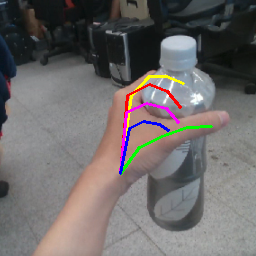

tensor([[[120.8835, 173.2885],
         [139.5163, 147.6381],
         [164.4242, 135.3131],
         [187.4738, 127.0443],
         [211.8694, 126.3261],
         [131.5821,  95.4714],
         [149.9445,  76.1770],
         [166.7753,  76.4128],
         [183.7354,  83.9504],
         [127.0697,  95.7980],
         [149.0771,  84.1823],
         [167.6258,  91.5616],
         [180.6746, 107.4911],
         [126.7586, 112.7802],
         [146.7591, 103.0796],
         [166.0593, 108.5312],
         [178.9290, 122.9910],
         [129.9633, 128.6131],
         [143.3845, 121.0324],
         [159.1398, 124.8198],
         [168.2576, 130.4828]]], device='cuda:0', grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

In [ ]:
ax = fig.add_subplot(2, 2, 2, projection="3d")
ax.title.set_text("flipped input")
displaymano.add_mesh(ax, noflip_verts, faces, flip_x=True)
# if "objpoints3d" in flip_output:
#   objverts = flip_output["objpoints3d"].cpu().detach().numpy()[0]
#   displaymano.add_mesh(ax, objverts, flip_output["objfaces"], flip_x=True, c="r" )
# flip_inpimage = deepcopy(np.flip(hand_crop, axis=1))
if "joints2d" in noflip_output:
  joints2d = noflip_output["joints2d"]
  noflip_inpimage = visualize_joints_2d_cv2(hand_crop, joints2d.cpu().detach().numpy()[0])
  ax = fig.add_subplot(2, 2, 3)
  ax.imshow(np.flip(noflip_inpimage[:, :, ::-1], axis=1))
  plt.show()
  cv2_imshow(noflip_inpimage)
 
  print(joints2d) 
  plt.savefig('readme_assets/images/out.png')

In [ ]:
# x = [1,2,3,4]
# y = [1,2,3,5]

# data = [
#     [1, 2],
#     [3, 2],
#     [4, 7],
#     [2, 4],
#     [2, 1],
#     [5, 6],
#     [6, 3],
#     [7, 5],
# ]

data = [ [120.8835, 173.2885],
         [139.5163, 147.6381],
         [164.4242, 135.3131],
         [187.4738, 127.0443],
         [211.8694, 126.3261],
         [131.5821,  95.4714],
         [149.9445,  76.1770],
         [166.7753,  76.4128],
         [183.7354,  83.9504],
         [127.0697,  95.7980],
         [149.0771,  84.1823],
         [167.6258,  91.5616],
         [180.6746, 107.4911],
         [126.7586, 112.7802],
         [146.7591, 103.0796],
         [166.0593, 108.5312],
         [178.9290, 122.9910],
         [129.9633, 128.6131],
         [143.3845, 121.0324],
         [159.1398, 124.8198],
         [168.2576, 130.4828] ]
x, y = zip(*data)

plt.scatter(x, y)
plt.show()

NameError: ignored

TypeError: ignored

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22294 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25240 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32218 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22294 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25240 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32218 missing from current font.
  font.set_text

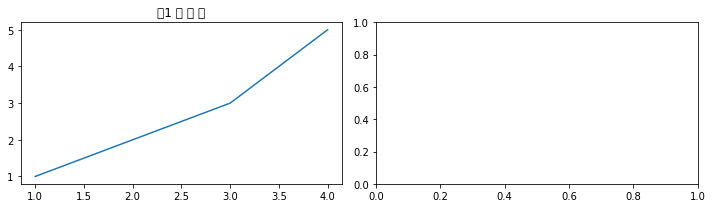

In [ ]:
# ax = fig.add_subplot(2, 2, 1)
# ax.imshow(np.flip(flip_inpimage[:, :, ::-1], axis=1))
# ax = fig.add_subplot(2, 2, 4, projection="3d")
# ax.title.set_text("unflipped input")
# displaymano.add_mesh(ax, noflip_verts, faces, flip_x=True)
# plt.show()
# plt.savefig('readme_assets/images/output.png')

In [ ]:
# # if "objpoints3d" in noflip_output:
# #   objverts = noflip_output["objpoints3d"].cpu().detach().numpy()[0]
# #   displaymano.add_mesh(ax, objverts, noflip_output["objfaces"], flip_x=True, c="r")
# # noflip_inpimage = deepcopy(hand_crop)
# if "joints2d" in flip_output:
#   joints2d = noflip_output["joints2d"]
#   noflip_inpimage = visualize_joints_2d_cv2(noflip_inpimage, joints2d.cpu().detach().numpy()[0])
# ax = fig.add_subplot(2, 2, 3)
# ax.imshow(np.flip(noflip_inpimage[:, :, ::-1], axis=1))
# # plt.show()
# plt.savefig('readme_assets/images/output.png')

In [ ]:
cv2_imshow

#Original code from
 https://github.com/hassony2/obman_train


In [ ]:

# parser = argparse.ArgumentParser()
# parser.add_argument("--resume",type=str,help="Path to checkpoint",default="release_models/obman/checkpoint.pth.tar",)
# parser.add_argument("--image_path",help="Path to image",default="readme_assets/images/1_1.jpg",)
# parser.add_argument("--no_beta", action="store_true", help="Force shape to average") 
# args = parser.parse_args()
# argutils.print_args(args)

# checkpoint = os.path.dirname(args.resume)
# with open(os.path.join(checkpoint, "opt.pkl"), "rb") as opt_f:
#   opts = pickle.load(opt_f)

# model = reload_model(args.resume, opts, no_beta=args.no_beta)

# model.eval()

# print(
# "Input image is processed flipped and unflipped "
# "(as left and right hand), both outputs are displayed"
# )

# with open("misc/mano/MANO_RIGHT.pkl", "rb") as p_f:
#   mano_right_data = pickle.load(p_f, encoding="latin1")
#   faces = mano_right_data["f"]

# fig = plt.figure(figsize=(4, 4))
# fig.clf()
# frame = cv2.imread(path_to_image)
# #    frame = cv2.imread(args.image_path)
# frame = preprocess_frame(frame)
# input_image = prepare_input(frame)
# img = Image.fromarray(frame.copy())
# hand_crop = cv2.resize(np.array(img), (256, 256))
# noflip_hand_image = prepare_input(hand_crop, flip_left_right=False)
# flip_hand_image = prepare_input(hand_crop, flip_left_right=True)
# noflip_output = forward_pass_2d(model, noflip_hand_image)
# flip_output = forward_pass_2d(model, flip_hand_image)
# flip_verts = flip_output["verts"].cpu().detach().numpy()[0]
# noflip_verts = noflip_output["verts"].cpu().detach().numpy()[0]

# ax = fig.add_subplot(2, 2, 2, projection="3d")
# ax.title.set_text("flipped input")
# displaymano.add_mesh(ax, flip_verts, faces, flip_x=True)
# if "objpoints3d" in flip_output:
#   objverts = flip_output["objpoints3d"].cpu().detach().numpy()[0]
#   displaymano.add_mesh(ax, objverts, flip_output["objfaces"], flip_x=True, c="r" )
# flip_inpimage = deepcopy(np.flip(hand_crop, axis=1))
# if "joints2d" in flip_output:
#   joints2d = flip_output["joints2d"]
#   flip_inpimage = visualize_joints_2d_cv2(
#   flip_inpimage, joints2d.cpu().detach().numpy()[0])
# print(flip_output)

# ax = fig.add_subplot(2, 2, 1)
# ax.imshow(np.flip(flip_inpimage[:, :, ::-1], axis=1))
# ax = fig.add_subplot(2, 2, 4, projection="3d")
# ax.title.set_text("unflipped input")
# displaymano.add_mesh(ax, noflip_verts, faces, flip_x=True)
# if "objpoints3d" in noflip_output:
#   objverts = noflip_output["objpoints3d"].cpu().detach().numpy()[0]
#   displaymano.add_mesh(ax, objverts, noflip_output["objfaces"], flip_x=True, c="r")
# noflip_inpimage = deepcopy(hand_crop)
# if "joints2d" in flip_output:
#   joints2d = noflip_output["joints2d"]
#   noflip_inpimage = visualize_joints_2d_cv2(noflip_inpimage, joints2d.cpu().detach().numpy()[0])
# ax = fig.add_subplot(2, 2, 3)
# ax.imshow(np.flip(noflip_inpimage[:, :, ::-1], axis=1))
# # plt.show()
# plt.savefig('readme_assets/images/output.png')

In [ ]:
# !nvidia-smi